In [6]:
# coding=utf-8
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys,math
import copy
sys.path.append('/disk1/home/wangrj/higherorder/signal')
sys.path.append('/disk1/home/wangrj/LDC/MLDC-master/software/LDCpipeline/scripts')
from pycbc import types,fft,noise,frame
from pycbc.filter import highpass,lowpass_fir, matched_filter,matched_filter_core,sigmasq
from pycbc.psd import welch, interpolate
from pycbc.psd.read import from_numpy_arrays
from pycbc.conversions import q_from_mass1_mass2,mchirp_from_mass1_mass2
from pycbc.conversions import mass1_from_mchirp_q,mass2_from_mchirp_q
from gensignal import gen_signal,gen_signal_fre,get_fd_htilde_lm,get_fd_LISATDI,func_wfTDI, get_TDI
from pycbc.waveform.utils import phase_from_frequencyseries,amplitude_from_frequencyseries
from pycbc.distributions import Uniform, JointDistribution, SinAngle,UniformAngle,UniformLog10
from pycbc.inference import models, sampler
from pycbc.inference import  sampler
import Cosmology
import LISAConstants as LC
from LISAhdf5 import LISAhdf5,ParsUnits
from pyFDresponse import *
from tdi import noisepsd_T,noisepsd_AE
from psd import parse_arguments,Series
from GenerateFD_SignalTDIs import ComputeTD
from LISACommonFunctions import FourierTransformData
import lal


In [7]:
def FLISA(t,lambd,beta,psi,t0):
    alpha= 2*np.pi*(t-t0)      #t,t0: yr
    #print(alpha)
    beta_L= np.arcsin(np.cos(np.pi/3)*np.sin(beta)-np.sin(np.pi/3)*np.cos(beta)*np.cos(lambd-alpha))
    lambd_L= np.arctan(np.cos(beta)*np.cos(lambd)*(np.cos(np.pi/3)*np.cos(alpha)**2+np.sin(alpha)**2)+\
                    np.cos(beta)*np.sin(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+\
                    np.sin(np.pi/3)*np.sin(beta)*np.cos(alpha)+\
                    np.cos(beta)*np.sin(lambd)*(np.cos(np.pi/3)*np.sin(alpha)**2+np.cos(alpha)**2)+\
                    np.cos(beta)*np.cos(lambd)*np.cos(alpha)*np.sin(alpha)*(np.cos(np.pi/3)-1)+
                    np.sin(np.pi/3)*np.sin(beta)*np.sin(alpha))
    psi_L= psi +np.arctan(np.cos(pi/3)*np.cos(beta)+np.sin(np.pi/3)*np.sin(beta)*np.cos(lambd-alpha)-np.sin(np.pi/3)*np.sin(lambd-alpha))

    F_a_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L-np.pi/3)/2
    F_a_cross = np.sin(beta_L)*np.sin(2*lambd_L-np.pi/3)
    F_e_plus = (1+np.sin(beta_L)**2)*np.cos(2*lambd_L+np.pi/6)/2
    F_e_cross = np.sin(beta_L)*np.sin(2*lambd_L+np.pi/6)
    #include the polarization angle in the pattern function
    Fa_plus = np.cos(2*psi_L)*F_a_plus + np.sin(2*psi_L) *F_a_cross
    Fe_plus = np.cos(2*psi_L)*F_e_plus + np.sin(2*psi_L) *F_e_cross
    Fa_cross = -np.sin(2*psi_L)*F_a_plus + np.cos(2*psi_L) *F_a_cross
    Fe_cross = -np.sin(2*psi_L)*F_e_plus + np.cos(2*psi_L) *F_e_cross
    return Fa_plus,Fa_cross,Fe_plus,Fe_cross


1000001


<function matplotlib.pyplot.show(*args, **kw)>

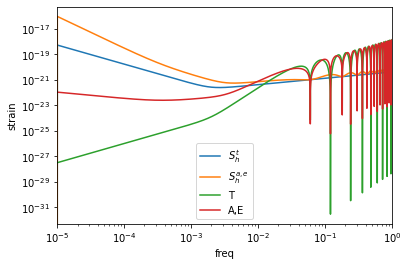

In [3]:
%matplotlib inline
#analytic PSD of noise for TDI A, E and T
del_f= 1e-6
f= np.arange(1e-5,1.0,del_f)
flen = int(1.0/del_f)+1
flow=1e-5
print(flen)
#freq= logsampling(1e-5,1.0,200)
PSD_TDIT= noisepsd_T(f)
PSD_TDIAE= noisepsd_AE(f)
L= 2.5e9/LC.c
PSD_TDIae= PSD_TDIAE/(2*np.sin(2*np.pi*f*L)**2)
PSD_TDIt= PSD_TDIT/(8*np.sin(np.pi*f*L)**2*np.sin(2*np.pi*f*L)**2)
#We can define a strain-like noise PSD
PSD_TDIae= PSD_TDIae/(6*np.pi*f*L)**2
PSD_TDIt= PSD_TDIt/(6*np.pi*f*L)**2

PSD_TDIt = from_numpy_arrays(f, PSD_TDIt, flen, del_f,flow)
PSD_TDIae = from_numpy_arrays(f, PSD_TDIae, flen, del_f,flow)

plt.loglog(PSD_TDIt.sample_frequencies,np.sqrt(PSD_TDIt*PSD_TDIt.sample_frequencies),label='$S^{t}_{h}$')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
plt.loglog(f,np.sqrt(PSD_TDIT*f),label='T')
plt.loglog(f,np.sqrt(PSD_TDIAE*f),label='A,E')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-0)
plt.legend()
plt.show

500001 500001
500001 500001


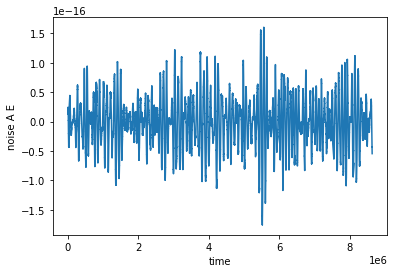

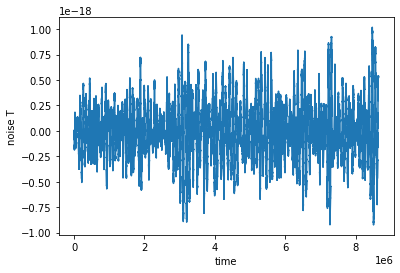

In [4]:
### Generate 1 year of noise 
Tobs=3600*24*100
del_t= 1
tsamples = int(Tobs / del_t)
noiseT = noise.noise_from_psd(tsamples, del_t, PSD_TDIt)
noiseAE = noise.noise_from_psd(tsamples, del_t, PSD_TDIae)
plt.plot(noiseAE.sample_times, noiseAE)
plt.xlabel('time')
plt.ylabel('noise A E')
plt.show()
plt.plot(noiseT.sample_times, noiseT)
plt.xlabel('time')
plt.ylabel('noise T')
plt.show()

Computing PSD for T (using 8640000 points at 1.0 Hz)...
Computing PSD for A (using 8640000 points at 1.0 Hz)...


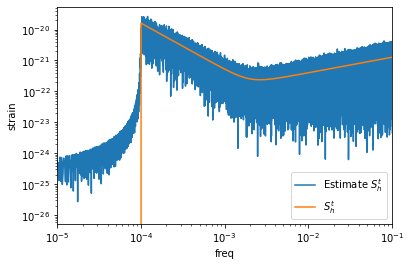

<function matplotlib.pyplot.show(*args, **kw)>

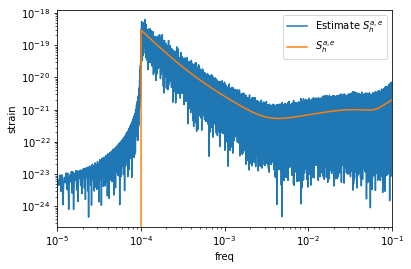

In [5]:
noise_T =Series(noiseT.sample_times,noiseT,'T')
psdT_estimated= noise_T.compute(nperseg=None, overlap=0.5, window='nuttall')

noise_AE =Series(noiseAE.sample_times,noiseAE,'A')
psdAE_estimated= noise_AE.compute(nperseg=None, overlap=0.5, window='nuttall')

# seg_len = int(10000 / del_t)
# seg_stride = int(seg_len / 2)
# psdAE_estimated = welch(noiseAE,
#                       seg_len=seg_len,
#                       seg_stride=seg_stride,
#                       avg_method='mean')
# psdT_estimated = welch(noiseT,
#                       seg_len=seg_len,
#                       seg_stride=seg_stride,
#                       avg_method='mean')
plt.loglog(psdT_estimated.frequencies,np.sqrt(psdT_estimated.psd*psdT_estimated.frequencies),label='Estimate $S^{t}_{h}$')
#plt.loglog(psdT_estimated.sample_frequencies,np.sqrt(psdT_estimated*psdT_estimated.sample_frequencies),label='Estimate $S^{t}_{h}$')
plt.loglog(PSD_TDIt.sample_frequencies,np.sqrt(PSD_TDIt*PSD_TDIt.sample_frequencies),label='$S^{t}_{h}$')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-1)
plt.legend()
plt.show()
plt.loglog(psdAE_estimated.frequencies,np.sqrt(psdAE_estimated.psd*psdT_estimated.frequencies),label='Estimate $S^{a,e}_{h}$')
#plt.loglog(psdAE_estimated.sample_frequencies,np.sqrt(psdAE_estimated*psdAE_estimated.sample_frequencies),label='Estimate $S^{a,e}_{h}$')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
plt.xlabel('freq')
plt.ylabel('strain')
plt.xlim(1e-5,1e-1)
plt.legend()
plt.show

Dl 6823.090480179816
t0,phi0,psi 0.05 0.0 0.8
m1,m2 200000.0 20000.0
0.1293770781809811 -0.33293768701526594 -0.13129416627259957 0.32433671781627404
2e-07 2097153 2097153


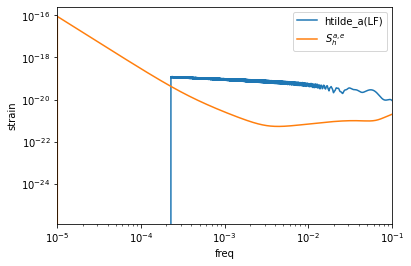

0.09090909090909088
-1.3424226808222066
0.001 0.09090909090909088


In [8]:
#generate the template waveform
##MBHBs parameters
z=1
m1s=2e5
m2s=2e4

#dimensionless spins: a=cos(theta_s)*s
chi1 = 0
chi2 = 0

#Tcs = 0.8 * LC.YRSID_SI
#t0= np.random.uniform(0.0,5.0)
t0=0.05
#Ecliptic Longitude, Latitude
theta=1.0
phi= 1.5
lambd =  phi
beta = np.pi/2 -theta

inc =  0.5
DL = Cosmology.DL(z, w=0)[0] # in Mpc
print('Dl',DL)

#phi0 = np.random.uniform(0.0, 2.0*np.pi)
#psi = np.random.uniform(0.0, 2.0*np.pi)   #pols=psi
psi=0.8
phi0= 0.0
print('t0,phi0,psi',t0,phi0,psi)
# So far, the only choice implemented: MLDC trajectories and TDI XYZ
[fRef, trajdict, TDItag] = [0., trajdict_MLDC, "TDIAET"]


#Masses quoted in the hdf5 files are always redshifted masses.
#m1 =  m1s*(1+z)  ### redshifted masses
#m2 =  m2s*(1+z)
m1=m1s
m2=m2s
print('m1,m2',m1,m2)
chirpmass=mchirp_from_mass1_mass2(m1,m2)
q=q_from_mass1_mass2(m1,m2)
#print(chirpmass,q)



apx=['SEOBNRv4HM','IMRPhenomXHM']
modes=[[[2,2]],[[2,2],[2,1],[3,2],[3,3],[4,4]]] 

#generate TDI data
f,hpf,hcf = gen_signal_fre(chirpmass,q,DL,inc,phi0,chi1,chi2,apx[1],modes[1])
Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
print(Fa_plus,Fa_cross,Fe_plus,Fe_cross)
htilde_a = Fa_plus*hpf + Fa_cross*hcf
htilde_e = Fe_plus*hpf + Fe_cross*hcf
tmp_ha= copy.deepcopy(htilde_a)
tmp_he= copy.deepcopy(htilde_e)
print(htilde_a.delta_f,len(htilde_a),len(htilde_e))

plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_a.sample_frequencies,label='htilde_a(LF)')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
#plt.axvline(x=50/(mass1_from_mchirp_q(chirpmass,q)+mass2_from_mchirp_q(chirpmass,q)),color='red')
#plt.axvline(x=2e4/(mass1_from_mchirp_q(chirpmass,q)+mass2_from_mchirp_q(chirpmass,q)))

plt.legend()
plt.xlim(1e-5,1e-1)
#plt.ylim(1e-26,1e-17)
plt.xlabel('freq')
plt.ylabel('strain')
plt.show()

#print(2e4/(mass1_from_mchirp_q(chirpmass,q)+mass2_from_mchirp_q(chirpmass,q)))
#print(4-math.log((mass1_from_mchirp_q(chirpmass,q)+mass2_from_mchirp_q(chirpmass,q)),10))
if(50/(mass1_from_mchirp_q(chirpmass,q)+mass2_from_mchirp_q(chirpmass,q))<=1e-4):
    fhigh=2e4/(mass1_from_mchirp_q(chirpmass,q)+mass2_from_mchirp_q(chirpmass,q))
    flow=1e-4
else:
    fhigh=np.minimum(1e-1,2e4/(mass1_from_mchirp_q(chirpmass,q)+mass2_from_mchirp_q(chirpmass,q)))
    flow=1e-3
print(flow,fhigh)

0.0889763611653656 0.17534606804768027 0.011934156659325915 0.46961738100122286

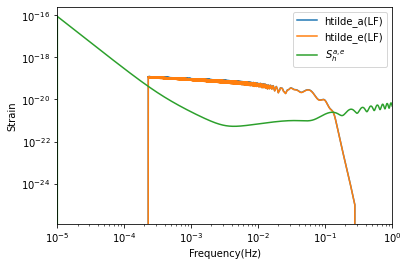

In [9]:
plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_a.sample_frequencies,label='htilde_a(LF)')
plt.loglog(htilde_a.sample_frequencies,abs(htilde_e)*htilde_a.sample_frequencies,label='htilde_e(LF)')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
plt.legend()
plt.xlim(1e-5,1e-0)
#plt.ylim(1e-26,1e-17)
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')

plt.show()

In [83]:
np.minimum(1e-2,2e4/(mass1_from_mchirp_q(chirpmass,q)+mass2_from_mchirp_q(chirpmass,q)))

0.01

without higher order

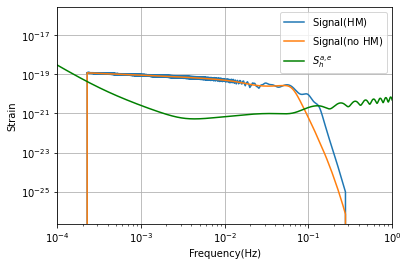

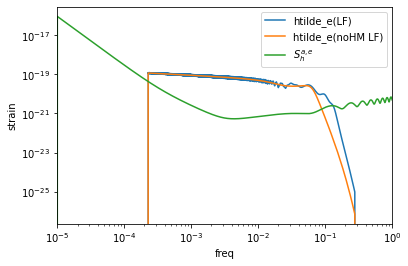

In [13]:
#without higher order
f,hpf_noHM,hcf_noHM = gen_signal_fre(chirpmass,q,DL,inc,phi0,chi1,chi2,apx[1],modes[0])
Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
htilde_a_noHM = Fa_plus*hpf_noHM + Fa_cross*hcf_noHM
htilde_e_noHM = Fe_plus*hpf_noHM + Fe_cross*hcf_noHM
tmp_ha_noHM= copy.deepcopy(htilde_a_noHM)
tmp_he_noHM= copy.deepcopy(htilde_e_noHM)


plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_a.sample_frequencies,label='$\\rm Signal(HM)$')
plt.loglog(htilde_a_noHM.sample_frequencies,abs(htilde_a_noHM)*htilde_a_noHM.sample_frequencies,label='$\\rm Signal(no\ HM)$')
#plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='$h_e^(LF)(HM)$')
#plt.loglog(htilde_e_noHM.sample_frequencies,abs(htilde_e_noHM)*htilde_e_noHM.sample_frequencies,label='$h_e^{LF}(no HM)$')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),color='green',linestyle='-',label='$S^{a,e}_{h}$')
plt.legend()
plt.xlim(1e-4,1e-0)
#plt.ylim(1e-26,1e-17)
plt.grid()
plt.xlabel('Frequency(Hz)')
plt.ylabel('Strain')
plt.savefig('htilde.pdf',dpi=300)
plt.show()

plt.loglog(htilde_e.sample_frequencies,abs(htilde_e)*htilde_e.sample_frequencies,label='htilde_e(LF)')
plt.loglog(htilde_e_noHM.sample_frequencies,abs(htilde_e_noHM)*htilde_e_noHM.sample_frequencies,label='htilde_e(noHM LF)')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
plt.legend()
plt.xlim(1e-5,1e-0)
#plt.ylim(1e-26,1e-17)
plt.xlabel('freq')
plt.ylabel('strain')
plt.show()

In [23]:
#compute SNR

psdAE = interpolate(PSD_TDIae,htilde_e.delta_f)
print(htilde_a.delta_f,psdAE.delta_f)
flow=1e-4
fhigh=1e-1
AA=sigmasq(htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
EE=sigmasq(htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh) 
snr = AA+EE

print(np.sqrt(snr),AA,EE)

2e-07 2e-07
447.3383876694301 102118.2022432545 97993.43083943086


In [25]:
for i in range(len(modes[1])):
    l,m= modes[1][i]
    print(l,m)
    f,hpf,hcf = gen_signal_fre(chirpmass,q,DL,inc,phi0,chi1,chi2,apx[1],[modes[1][i]])
    Fa_plus,Fa_cross,Fe_plus,Fe_cross= FLISA(t0,lambd,beta,psi,0)
    #print(Fa_plus,Fa_cross,Fe_plus,Fe_cross)
    htilde_a = Fa_plus*hpf + Fa_cross*hcf
    htilde_e = Fe_plus*hpf + Fe_cross*hcf
    AA=sigmasq(htilde_a,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh)
    EE=sigmasq(htilde_e,psd=psdAE, low_frequency_cutoff=flow,high_frequency_cutoff=fhigh) 
    snr = AA+EE
    print(l,m,np.sqrt(snr))

2 2
2 2 438.0573936571303
2 1
2 1 13.817559005771088
3 2
3 2 6.3082058192674015
3 3
3 3 59.639999587317256
4 4
4 4 8.825605127888645


generate a TD TDI 

2097153 2500001.0
hf frequency [0.000000e+00 2.000000e-07 4.000000e-07 ... 4.999996e-01 4.999998e-01
 5.000000e-01]


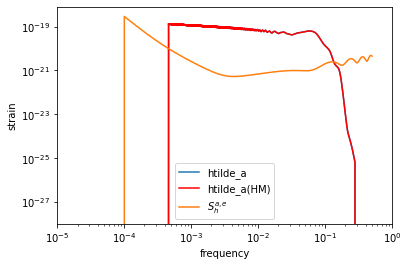

In [10]:
#FFT it to the time-domain
tlen = int(1.0 / del_t / htilde_a.delta_f)
print(len(htilde_a),tlen/2+1)
tmp_ha.resize(tlen/2+1)
tmp_he.resize(tlen/2+1)
tmp_ha_noHM.resize(tlen/2+1)
tmp_he_noHM.resize(tlen/2+1)

print('hf frequency',tmp_ha.sample_frequencies)

plt.loglog(htilde_a.sample_frequencies,abs(htilde_a)*htilde_a.sample_frequencies,label='htilde_a')
plt.loglog(tmp_ha.sample_frequencies,abs(tmp_ha)*tmp_ha.sample_frequencies,label='htilde_a(HM)',color='red')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
plt.xlim(1e-5,1)
plt.xlabel('frequency')
plt.ylabel('strain')
plt.legend()
plt.show()
#################################

##################################
ht_a_noHM=tmp_ha_noHM.to_timeseries()
ht_a_HM=tmp_ha.to_timeseries()
ht_e_noHM=tmp_he_noHM.to_timeseries()
ht_e_HM=tmp_he.to_timeseries()



/home/wrj/anaconda2/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


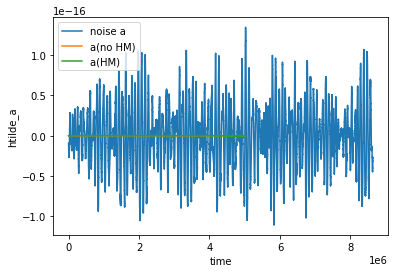

/home/wrj/anaconda2/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


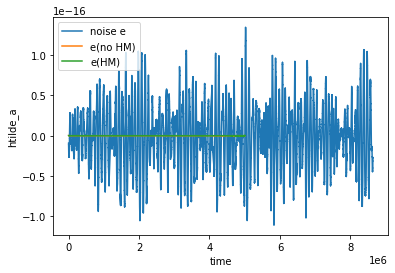

dt 1.0 1.0 1
duration 5000000.0 8640000
df 2e-07 2e-07


In [9]:

plt.plot(noiseAE.sample_times, noiseAE,label='noise a')
plt.plot(ht_a_noHM.sample_times,ht_a_noHM,label='a(no HM)')
plt.plot(ht_a_HM.sample_times,ht_a_HM,label='a(HM) ')
plt.xlabel('time')
plt.ylabel('htilde_a')
plt.legend()
plt.show()

plt.plot(noiseAE.sample_times, noiseAE,label='noise e')
plt.plot(ht_e_noHM.sample_times,ht_e_noHM,label='e(no HM)')
plt.plot(ht_e_HM.sample_times,ht_e_HM,label='e(HM)')
plt.xlabel('time')
plt.ylabel('htilde_a')
plt.legend()
plt.show()


print('dt',ht_a_HM.delta_t,ht_e_HM.delta_t,noiseAE.delta_t)
print('duration',ht_a_HM.duration,noiseAE.duration)
print('df',tmp_ha.delta_f,ht_a_HM.delta_f)

[0.000000e+00 2.000000e-07 4.000000e-07 ... 4.999996e-01 4.999998e-01
 5.000000e-01]
[0.000000e+00 2.000000e-07 4.000000e-07 ... 4.999996e-01 4.999998e-01
 5.000000e-01]


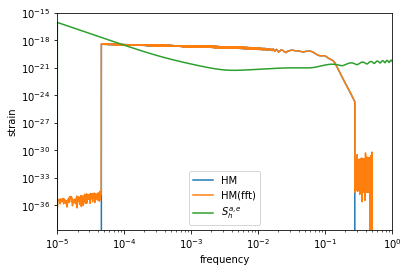

In [10]:
#check the characteristics strain
hf_a_HM_fft=ht_a_HM.to_frequencyseries()
hf_a_noHM_fft=ht_a_noHM.to_frequencyseries()
print(tmp_ha.sample_frequencies)
print(hf_a_HM_fft.sample_frequencies)

plt.loglog(tmp_ha.sample_frequencies,abs(tmp_ha)*tmp_ha.sample_frequencies,label='HM')
plt.loglog(hf_a_HM_fft.sample_frequencies,abs(hf_a_HM_fft)*hf_a_HM_fft.sample_frequencies,label='HM(fft)')
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')

plt.xlim(1e-5,1)
plt.legend()
plt.xlabel('frequency')
plt.ylabel('strain')
plt.show()

In [ ]:
fft_noise=noiseAE.to_frequencyseries()
plt.loglog(fft_noise.sample_frequencies,abs(fft_noise),label='noise')
plt.loglog(hf_a_HM_fft.sample_frequencies,abs(hf_a_HM_fft),label='signal a')
plt.xlim(1e-4,1)
plt.legend()
plt.ylabel('|n(f)|')
plt.xlabel('Freq')
plt.show()

generate the data

In [12]:
#signal + noise

tstart = int(t0*365*24*3600/del_t)
strainA = types.TimeSeries(noiseAE.data.data[:],delta_t=noiseAE.delta_t)
strainE = types.TimeSeries(noiseAE.data.data[:],delta_t=noiseAE.delta_t)

print(ht_a_HM.sample_times,ht_a_HM.duration,ht_a_HM.delta_t)
tmp_htA =types.TimeSeries(ht_a_HM.data.data[:],delta_t=ht_a_HM.delta_t)
tmp_htE =types.TimeSeries(ht_e_HM.data.data[:],delta_t=ht_e_HM.delta_t)


nlen=len(strainA)
tlen=len(tmp_htA)
#tstart=np.r

print('dt',tmp_htA.delta_t,strainA.delta_t)
print('df',tmp_htA.delta_f,strainA.delta_f,1.0/strainA.duration)
print(nlen,tlen,tstart)


[0.000000e+00 1.000000e+00 2.000000e+00 ... 4.999997e+06 4.999998e+06
 4.999999e+06] 5000000.0 1.0
dt 1.0 1
df 2e-07 1.1574074074074074e-07 1.1574074074074074e-07
8640000 5000000 3153600


In [13]:
tmp_htA.start_time = tstart *tmp_htA.delta_t     
tmp_htE.start_time = tstart *tmp_htE.delta_t   

print(strainA.sample_times[tstart])
print('noise',strainA[tstart:tstart+tlen])
print('signal',tmp_htA[0:tlen])
strainA[tstart:tstart+tlen]= strainA[tstart:tstart+tlen] +tmp_htA[0:tlen]
strainE[tstart:tstart+tlen]= strainE[tstart:tstart+tlen] +tmp_htE[0:tlen]
print('signal+noise',strainA[tstart:tstart+tlen])


3153600.0
noise [8.17841899e-17 8.17969871e-17 8.17970576e-17 ... 1.12142370e-17
 1.12092643e-17 1.11966891e-17]
signal [-2.74837665e-20 -4.68484695e-20 -6.28703787e-20 ...  3.70876935e-20
  1.58002287e-20 -6.15253885e-21]
signal+noise [8.17567061e-17 8.17501386e-17 8.17341872e-17 ... 1.12513247e-17
 1.12250645e-17 1.11905366e-17]


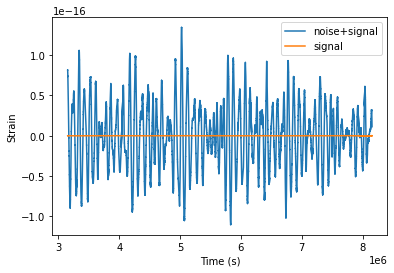

In [14]:

plt.plot(strainA[tstart:tstart+tlen].sample_times,strainA[tstart:tstart+tlen],label='noise+signal')
#plt.plot(times[100000:100000+tlen],noise[100000:100000+tlen],label='noise')

plt.plot(tmp_htA[0:tlen].sample_times, tmp_htA[0:tlen],label='signal')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

[ 5.84762404e-20  4.13081270e-20  2.36467600e-20 ... -2.25317834e-19
 -2.40096169e-19 -2.51532419e-19]


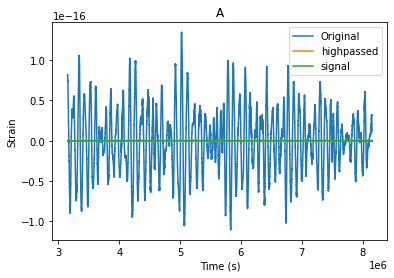

/home/wrj/anaconda2/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


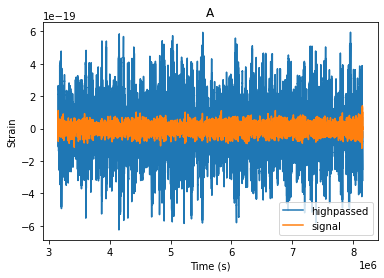

In [15]:
plt.plot(strainA[tstart:tstart+tlen].sample_times,strainA[tstart:tstart+tlen],label='Original')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
#remove low frequency content
dataA=highpass(strainA,1e-4)
dataA=lowpass_fir(dataA,0.1,512)
dataE=highpass(strainE,1e-4)
dataE=lowpass_fir(dataE,0.1,512)
#data=highpass_fir(strain,1e-3,8)
#data=copy.deepcopy(strain)
print(dataA[tstart:tstart+tlen])
plt.plot(dataA.sample_times[tstart:tstart+tlen],dataA[tstart:tstart+tlen],label='highpassed')
plt.plot(tmp_htA[0:tlen].sample_times, tmp_htA[0:tlen],label='signal')
plt.title('A')
plt.legend()
plt.show()

plt.plot(dataA.sample_times[tstart:tstart+tlen],dataA[tstart:tstart+tlen],label='highpassed')
plt.plot(tmp_htA[0:tlen].sample_times, tmp_htA[0:tlen],label='signal')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.title('A')
plt.legend()
plt.show()

/home/wrj/anaconda2/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


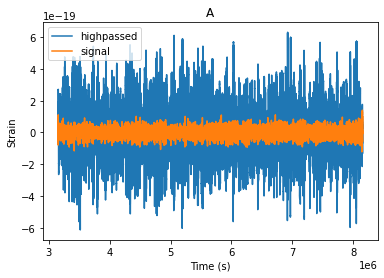

In [35]:
plt.plot(dataA.sample_times[tstart:tstart+tlen],dataA[tstart:tstart+tlen],label='highpassed')
plt.plot(tmp_htA[0:tlen].sample_times, tmp_htA[0:tlen],label='signal')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.title('A')
plt.legend()
plt.show()

Text(0.5, 0, 'Frequency (Hz)')

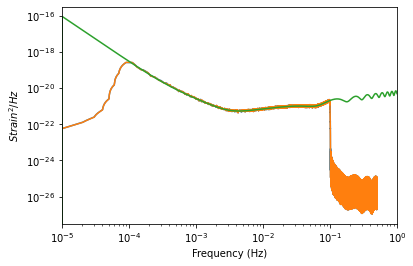

In [36]:
#calculate the noise spectrum
seg_len = int(100000 / dataA.delta_t)
seg_stride = int(seg_len / 2)
psdA = interpolate(welch(dataA,seg_len=seg_len,seg_stride=seg_stride),dataA.delta_f)
psdE = interpolate(welch(dataE,seg_len=seg_len,seg_stride=seg_stride),dataE.delta_f)
#psd = inverse_spectrum_truncation(psd, int(200000 * data.sample_rate),
#                                  low_frequency_cutoff=1.0e-5)
plt.loglog(psdA.sample_frequencies, np.sqrt(psdA.sample_frequencies*psdA))
plt.loglog(psdE.sample_frequencies, np.sqrt(psdE.sample_frequencies*psdE))
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
plt.xlim(1e-5,1)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
#pylab.xlim(30, 1024)

[0.00000000e+00 1.15740741e-07 2.31481481e-07 ... 4.99999769e-01
 4.99999884e-01 5.00000000e-01]


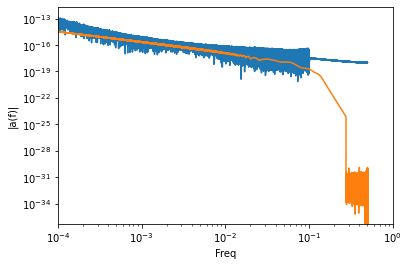

Text(0.5, 0, 'Freq')

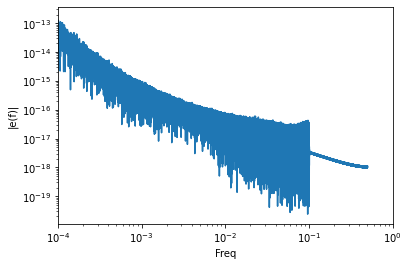

In [37]:
Af =dataA.to_frequencyseries()   # Convert to a frequency series by taking the data's FFT
Ef =dataE.to_frequencyseries() 
#fft.fft(data,sf)

print(Af.sample_frequencies)

plt.loglog(Af.sample_frequencies,abs(Af))
plt.loglog(hf_a_HM_fft.sample_frequencies,abs(hf_a_HM_fft),label='signal a')
plt.xlim(1e-4,1)
plt.ylabel('|a(f)|')
plt.xlabel('Freq')
plt.show()

plt.loglog(Ef.sample_frequencies,abs(Ef))
plt.xlim(1e-4,1)
plt.ylabel('|e(f)|')
plt.xlabel('Freq')

5000000 8640000
1.1574074074074074e-07 1.1574074074074074e-07 1.1574074074074074e-07 1.1574074074074074e-07
8640000 8640000


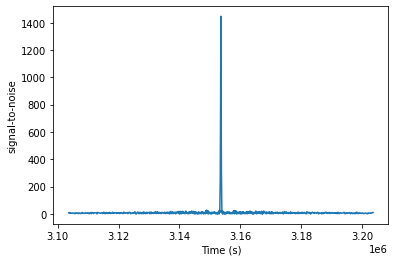

3153600.0 1447.364073545193


In [39]:
#calculate the Signal-to-noise time series 
print(len(tmp_htA),len(dataA))
tmphtA=copy.deepcopy(tmp_htA)
tmphtA.resize(len(dataA))
tmphtE=copy.deepcopy(tmp_htE)
tmphtE.resize(len(dataE))
print(tmphtA.delta_f,dataA.delta_f,psdA.delta_f,psdE.delta_f)
print(len(dataA),len(tmphtA))
snr = matched_filter(tmphtA, dataA,psd=psdA, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)+\
      matched_filter(tmphtE, dataE,psd=psdE, low_frequency_cutoff=1e-4,high_frequency_cutoff=1e-2)
snr = snr[tstart-50000:tstart+50000]
#Now we should be able to spot where the signal is!
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('signal-to-noise')
plt.xlabel('Time (s)')
plt.show()
dexmax=np.argmax(snr)
print(snr.sample_times[dexmax],abs(snr[dexmax]))

1.0


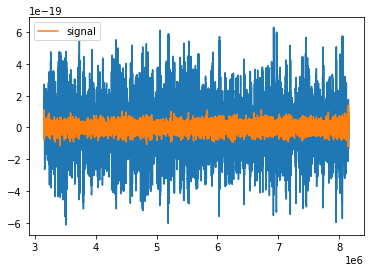

Text(0.5, 0, 'Frequency (Hz)')

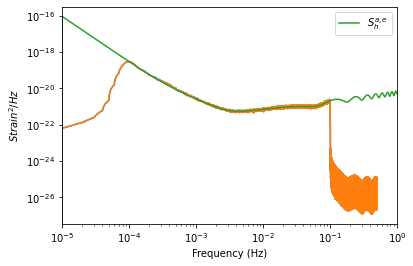

In [40]:
#Limit to times around the signal
dataA1 = dataA.time_slice(tstart*dataA.delta_t,tstart*dataA.delta_t+tlen*dataA.delta_t)
dataE1 = dataE.time_slice(tstart*dataE.delta_t,tstart*dataE.delta_t+tlen*dataE.delta_t)
print(dataA1.delta_t)    
#data=highpass_fir(data1,1e-3,8) 
plt.plot(dataA1.sample_times,dataA1)
plt.plot(tmphtA[0:tlen].sample_times, tmphtA[0:tlen],label='signal')
plt.legend()
plt.show()
plt.clf()
# Estimate the power spectral density of the data
# This chooses to use 200000s samples in the PSD estimate.
seg_len = int(100000 / dataA1.delta_t)
seg_stride = int(seg_len / 2)
psdA1 = interpolate(welch(dataA1,seg_len=seg_len,seg_stride=seg_stride),1.0/dataA1.duration)
psdE1 = interpolate(welch(dataE1,seg_len=seg_len,seg_stride=seg_stride),1.0/dataE1.duration)


plt.loglog(psdA1.sample_frequencies, np.sqrt(psdA1.sample_frequencies*psdA1))
plt.loglog(psdE1.sample_frequencies, np.sqrt(psdE1.sample_frequencies*psdE1))
plt.loglog(PSD_TDIae.sample_frequencies,np.sqrt(PSD_TDIae*PSD_TDIae.sample_frequencies),label='$S^{a,e}_{h}$')
plt.xlim(1.0e-5,1)
plt.legend()
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')

[4.68692197e-16+0.00000000e+00j 4.68694823e-16-5.35320735e-20j
 4.68702704e-16-1.07073675e-19j ... 7.07411252e-20-7.64975331e-23j
 7.05012414e-20-3.01372131e-23j 7.05587412e-20+0.00000000e+00j]
delta_f 2e-07
[0.000000e+00 2.000000e-07 4.000000e-07 ... 4.999996e-01 4.999998e-01
 5.000000e-01]


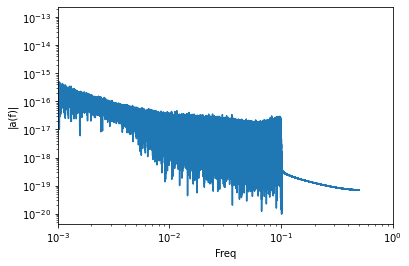

In [41]:
af =dataA1.to_frequencyseries()   # Convert to a frequency series by taking the data's FFT
ef =dataE1.to_frequencyseries()
print(af)
#fft.fft(data1,df)
print('delta_f',af.delta_f)
print(af.sample_frequencies)

plt.loglog(af.sample_frequencies,abs(af),label='Data(with noise)')
plt.xlim(1e-4,1)
plt.ylabel('|a(f)|')
plt.xlabel('Freq')
plt.xlim(1e-3,1)
plt.show()


tmpa=copy.deepcopy(af)
tmpe=copy.deepcopy(ef)

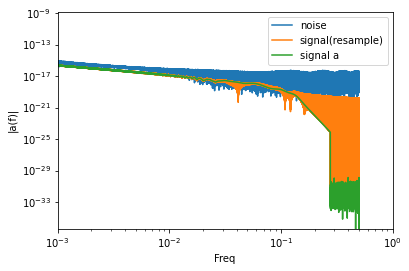

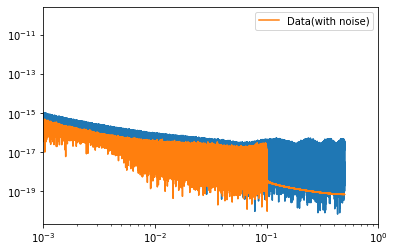

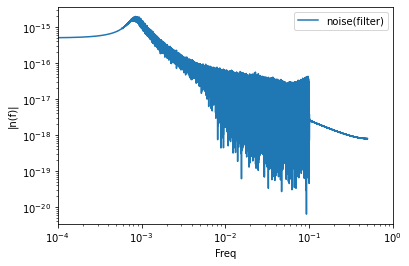

In [47]:
fft_noise=noiseAE.to_frequencyseries()
tmp_haf=tmphtA.to_frequencyseries()
plt.loglog(fft_noise.sample_frequencies,abs(fft_noise),label='noise')
plt.loglog(tmp_haf.sample_frequencies,abs(tmp_haf),label='signal(resample)')
plt.loglog(hf_a_HM_fft.sample_frequencies,abs(hf_a_HM_fft),label='signal a')
plt.xlim(1e-3,1)
plt.legend()
plt.ylabel('|a(f)|')
plt.xlabel('Freq')
plt.show()

plt.loglog(fft_noise.sample_frequencies,abs(fft_noise+tmp_haf))
plt.loglog(af.sample_frequencies,abs(af),label='Data(with noise)')
plt.xlim(1e-3,1)
plt.legend()
plt.show()

noiseAE_fir= highpass(noiseAE,1e-3)
noiseAE_fir= lowpass_fir(noiseAE_fir,1e-1,512)
fft_noise_fir =noiseAE_fir.to_frequencyseries()
plt.loglog(fft_noise_fir.sample_frequencies,abs(fft_noise_fir),label='noise(filter)')
plt.xlim(1e-4,1)
plt.legend()
plt.ylabel('|n(f)|')
plt.xlabel('Freq')
plt.show()



In [6]:
static = {#'chirpmass':chirpmass,
          'q':q,
          'distance':DL,
          'inc':inc,
          'phi0':phi0,
          'chi1':chi1,
          'chi2':chi2,
          'lambd':lambd,
          'beta':beta,
          'psi':psi,
          't0':t0,
          'trajdict':trajdict,
          'TDItag':TDItag,
          'apx':apx[1],
          'modes':modes[0]
          #'f_lower':1.0e-3
         }
variable = [
            'chirpmass'
            ]
#print(len(static))
#freqs, A,E,T =get_TDI(**static)
prior = JointDistribution(variable,Uniform(chirpmass=(chirpmass-80,chirpmass+80)))
print(prior(chirpmass=chirpmass))

-5.075173815233827


In [7]:
from templateTDI import TemplateTDI
model_HM =  TemplateTDI(variable,copy.deepcopy(data),
                    low_frequency_cutoff={'LISATDI1':1e-4,'LISATDI2':1e-4,'LISATDI3':1e-4},
                    high_frequency_cutoff={'LISATDI1':1e-1,'LISATDI2':1e-1,'LISATDI3':1e-1},
                    psds = psds,
                    static_params = static,
                    prior = prior,
                    sample_rate = 1,
                    )


delta_f,delta_t 2e-07 5.0


In [8]:
 smpl = sampler.DynestySampler(model_HM, nlive=100, nprocesses=10,use_mpi=True) 
# #_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

# smpl.run()